<h2 style="color: chocolate;">Pauta Tarea N°1</h2>

---

<b>Profesor: Pedro Luiz Ramos 
<br>
<b> Ayudante: Diego Bernal

## Ejercicio

Trabajaremos con el conjunto **Wine Data** del repositorio UCI:  
[https://archive.ics.uci.edu/ml/datasets/wine](https://archive.ics.uci.edu/ml/datasets/wine)

El archivo contiene **178 observaciones** de tres cultivares de vino tinto de la región de Piamonte (Italia). Para cada muestra se midieron **13 atributos físico-químicos** y una **etiqueta de clase (1, 2 o 3)**.

### Objetivo general:
Explorar, reducir la dimensión de los datos y construir modelos de regresión para **predecir el contenido de Proline** a partir de las demás variables.


## Descripción de las variables

| Variable            | Descripción                                 |
|---------------------|----------------------------------------------|
| Class               | Cultivar de origen (1, 2, 3)                 |
| Alcohol             | Contenido de alcohol (%)                    |
| Malic               | Ácido málico (g/L)                          |
| Ash                 | Cenizas (g/L)                               |
| Alcalinity          | Alcalinidad de las cenizas (meq NaOH)       |
| Magnesium           | Magnesio (mg/L)                             |
| Total phenols       | Fenoles totales (g/L)                       |
| Flavanoids          | Flavonoides (g/L)                           |
| Nonflav phenols     | Fenoles no flavonoides (g/L)                |
| Proanthocyanins     | Proantocianidinas (g/L)                     |
| Color intensity     | Intensidad de color (u.a.)                  |
| Hue                 | Matiz (ratio 420/520 nm)                    |
| OD280/OD315         | OD280/OD315 en vinos diluidos               |
| Proline             | Prolina (mg/L) — variable respuesta         |

In [106]:
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from ucimlrepo import fetch_ucirepo 
  
wine = fetch_ucirepo(id=109) 
  
# data (as pandas dataframes) 
X = wine.data.features 
y = wine.data.targets 
  
# metadata 
print(wine.metadata) 
  
# variable information 
print(wine.variables) 


## 1. Estadística descriptiva (1.5 pts)

- Tipifica todas las variables cuantitativas.
- Presenta tabla con:
  - medias
  - desviaciones estándar
  - mínimos y máximos
- Incluye:
  - un `corrplot`
  - histogramas
  - boxplots
- Detecta valores atípicos mediante la **regla IQR** y discútelos brevemente.


In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA 
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from models import ols,stratified_sampling, rss, r_squared
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import RidgeCV

In [8]:
#Se define una función a la cual se le entrega como argumentos un df y un titulo 
def show(df, title=''): 
    filas, cols = df.shape  #se declaran las variables con la cantidad de filas y columnas del df original graciasa .shape
    filas_selec = df.iloc[[0, 1, 2, -3, -2, -1]] #se genera un df con las 3 primeras filas y las 3 ultimas
    caption = f"{title}<br>Shape: {filas} Filas × {cols} Columnas.<br> " #se crea el titulo con lo solicitado
    display(filas_selec.style.set_caption(caption)) #se le agrrega al df el titulo creado

In [9]:
title = 'Set de datos de Vinos'
show(X,title)

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
0,14.230000,1.710000,2.430000,15.600000,127,2.800000,3.060000,0.280000,2.290000,5.640000,1.040000,3.920000,1065
1,13.200000,1.780000,2.140000,11.200000,100,2.650000,2.760000,0.260000,1.280000,4.380000,1.050000,3.400000,1050
2,13.160000,2.360000,2.670000,18.600000,101,2.800000,3.240000,0.300000,2.810000,5.680000,1.030000,3.170000,1185
175,13.270000,4.280000,2.260000,20.000000,120,1.590000,0.690000,0.430000,1.350000,10.200000,0.590000,1.560000,835
176,13.170000,2.590000,2.370000,20.000000,120,1.650000,0.680000,0.530000,1.460000,9.300000,0.600000,1.620000,840
177,14.130000,4.100000,2.740000,24.500000,96,2.050000,0.760000,0.560000,1.350000,9.200000,0.610000,1.600000,560


In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alcohol                       178 non-null    float64
 1   Malicacid                     178 non-null    float64
 2   Ash                           178 non-null    float64
 3   Alcalinity_of_ash             178 non-null    float64
 4   Magnesium                     178 non-null    int64  
 5   Total_phenols                 178 non-null    float64
 6   Flavanoids                    178 non-null    float64
 7   Nonflavanoid_phenols          178 non-null    float64
 8   Proanthocyanins               178 non-null    float64
 9   Color_intensity               178 non-null    float64
 10  Hue                           178 non-null    float64
 11  0D280_0D315_of_diluted_wines  178 non-null    float64
 12  Proline                       178 non-null    int64  
dtypes: fl

In [49]:
X = X.rename(columns={'0D280_0D315_of_diluted_wines':'OD280/OD315'})

In [50]:
des = X.describe().T
des

,count,mean,std,min,25%,50%,75%,max
Alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
Malicacid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
Ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
Alcalinity_of_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
Magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
Total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
Flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
Nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
Proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
Color_intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


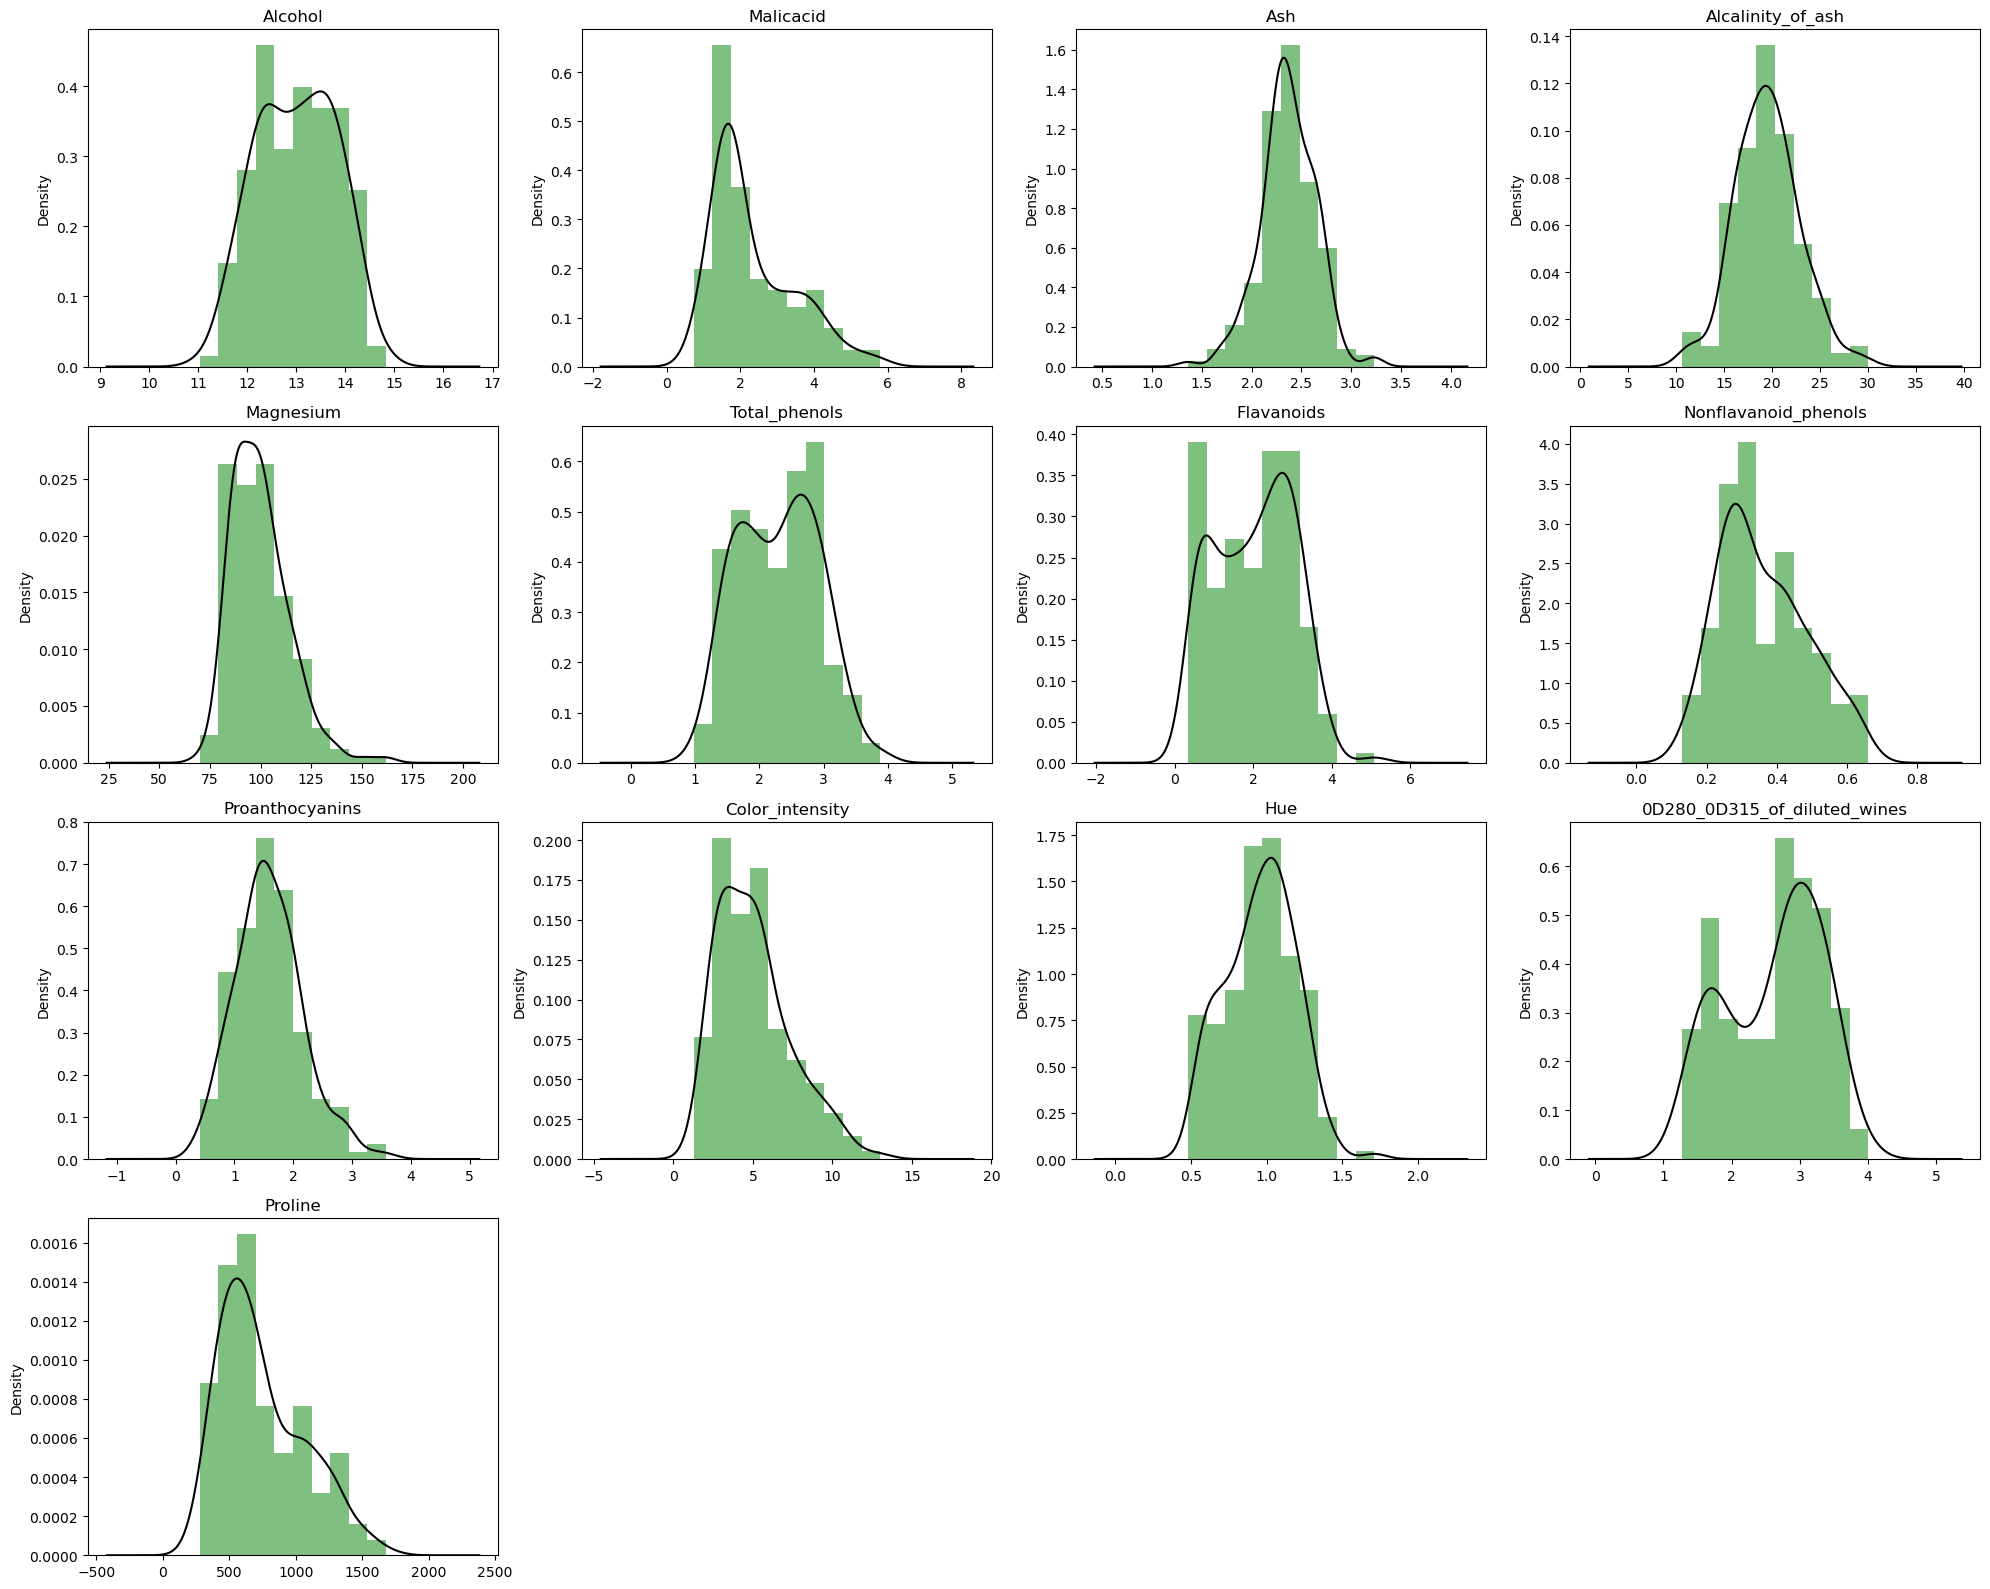

In [23]:
fig, axes = plt.subplots(4, 4, figsize=(5*4, 4*4)) #Se genera una figura con 1 fila con varios plots, se utiliza el largo de las cols para ajustar el ancho para que tengan mas  espacio
axes = np.array(axes).reshape(-1)
for i, col in enumerate(X.columns):#Iterador que utiliza las columnas y su indice
    ax = axes[i]  # Declaramos ax para trabajar con el subplot correspondiente
    X[col].plot(kind='hist', density=True,color="green", ax=ax, alpha=0.5) #Genera un hist para la variable col
    X[col].plot(kind='kde', ax=ax, color='black') #Genra una distri de kernel para la variable col
    ax.set_title(col)#Establece el titulo para la variable col utilizandola

for j in range(len(X.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [26]:
X['class'] = y

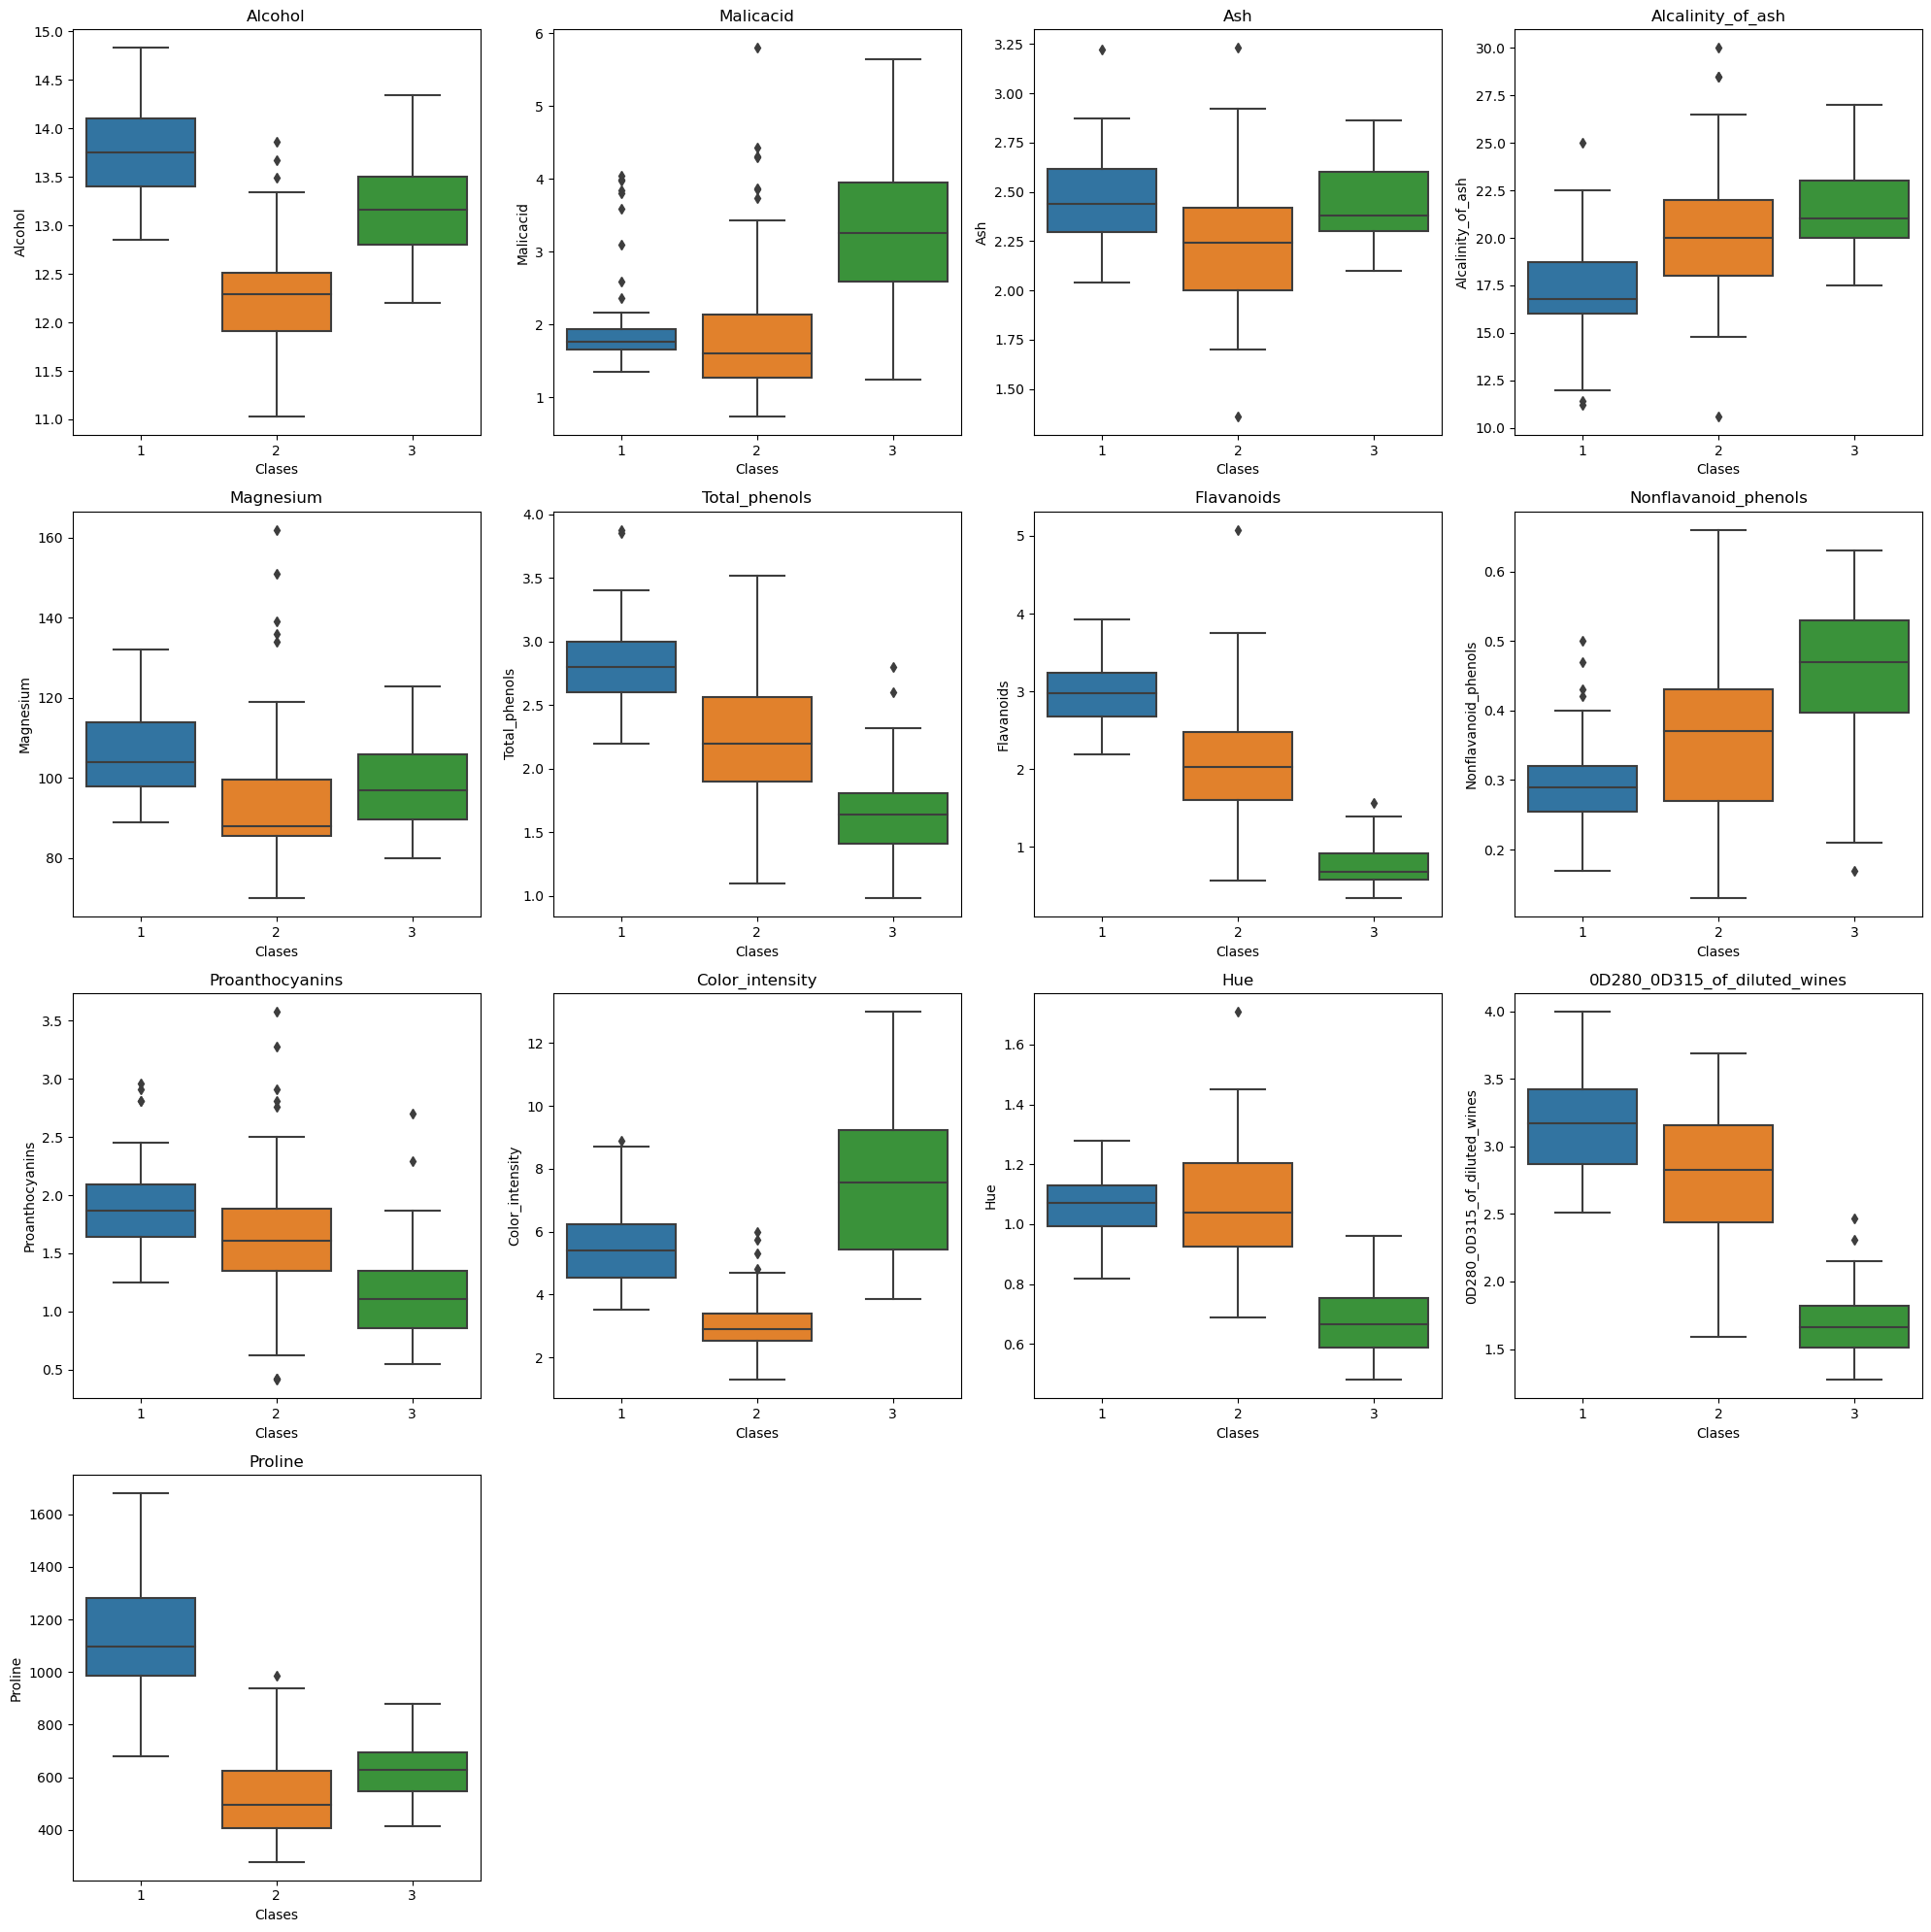

In [35]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20)) #Se genera una figura con 1 fila de subplots de los cuales se generan segun las dim de 
axes = axes.flatten() 
for i, col in enumerate(X.columns[:-1]): #Iterador a trav+es de ñas columnas del df que utiliza su indice como la columna
    ax = axes[i] # Declaramos ax para trabajar con el subplot correspondiente
    sns.boxplot(x='class', y=col, data=X, ax=ax) #utilizamos la biblioteca seaborn para generar los histogramas correspondientes
    ax.set_title(col) #Layers
    ax.set_xlabel('Clases'); ax.set_ylabel(col)

for j in range(len(X.columns[:-1]), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [51]:
corr = X.iloc[:, :-1].corr()

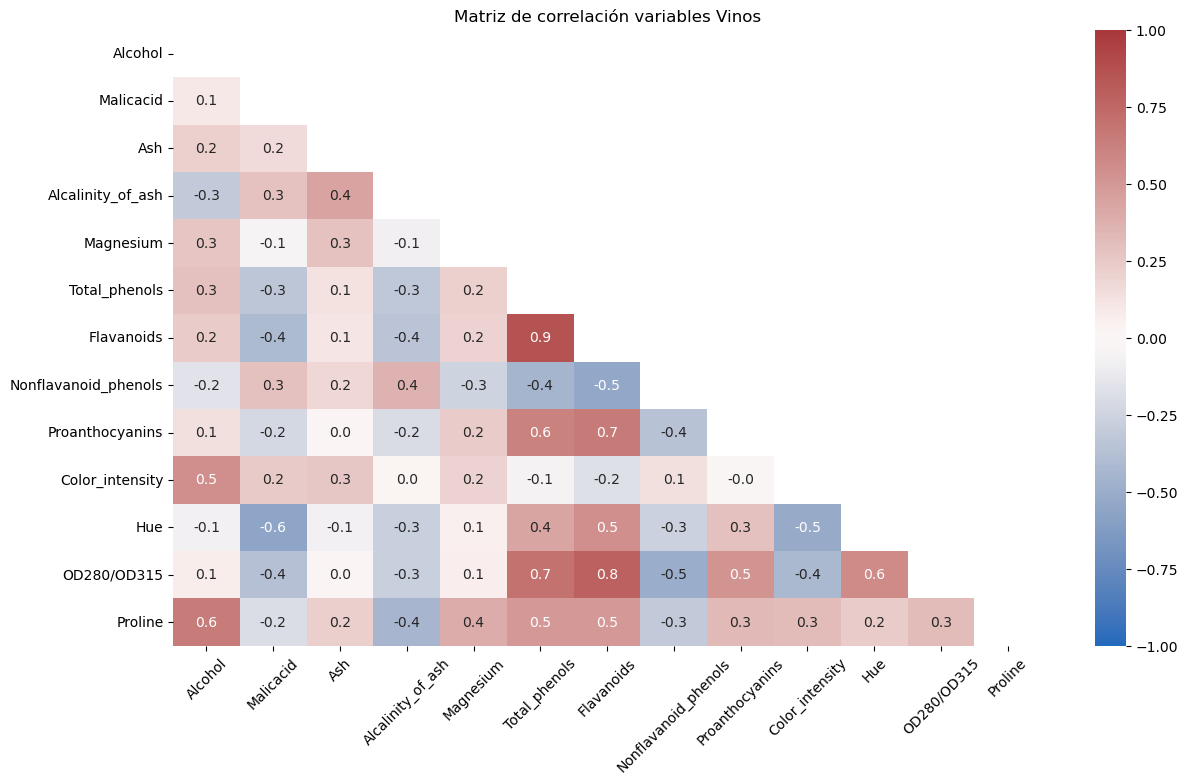

In [54]:
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(14, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap='vlag', vmin=-1, vmax=1, fmt='.1f')

plt.title('Matriz de correlación variables Vinos')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [71]:
def outliers(df):
    for col in df.columns[:-1]:

        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1- 1.5*iqr
        upper = q3 + 1.5*iqr
        outliers = df[(df[col] < lower) | (df[col] > upper)]

        if not outliers.empty:
            print(f"Columna: {col}")
            print(f"Cantidad de outliers: {len(outliers)}")
            print(f"{outliers[col].drop_duplicates().values}")
            print(f"{outliers[[col]].head().to_string()}\n" )



In [73]:
outliers(X)

Columna: Malicacid
Cantidad de outliers: 3
[5.8  5.51 5.65]
     Malicacid
123       5.80
137       5.51
173       5.65

Columna: Ash
Cantidad de outliers: 3
[3.22 1.36 3.23]
      Ash
25   3.22
59   1.36
121  3.23

Columna: Alcalinity_of_ash
Cantidad de outliers: 4
[10.6 30.  28.5]
     Alcalinity_of_ash
59                10.6
73                30.0
121               28.5
127               28.5

Columna: Magnesium
Cantidad de outliers: 4
[151 139 136 162]
    Magnesium
69        151
73        139
78        136
95        162

Columna: Proanthocyanins
Cantidad de outliers: 2
[3.28 3.58]
     Proanthocyanins
95              3.28
110             3.58

Columna: Color_intensity
Cantidad de outliers: 4
[10.8  13.   11.75 10.68]
     Color_intensity
151            10.80
158            13.00
159            11.75
166            10.68

Columna: Hue
Cantidad de outliers: 1
[1.71]
      Hue
115  1.71



<li>Histogramas y distribución</li>
<ul><p> Como se puede observar en los histogramas generados, varias variables del dataset presentan distribuciones no simétricas, es decir, con **skewness**. La variable <b>Malicacid</b> presenta un skewness positivo, evidenciado por su cola derecha, lo que indica la existencia de valores extremos superiores. Este mismo comportamiento se aprecia en <b>Color_intensity</b> y <b>Proline</b>, donde hay una concentración de valores bajos y unos pocos valores atípicamente altos.<br><br>
En contraste, variables como <b>Ash</b>, <b>Total_phenols</b> y <b>Hue</b> presentan distribuciones más cercanas a la simetría (skewness cercano a cero), lo cual es deseable en muchos métodos estadísticos. Estas diferencias en la forma de las distribuciones deben considerarse si se desea aplicar técnicas de modelado predictivo, especialmente aquellas sensibles a la normalidad de los datos. Para variables con skewness pronunciado, sería recomendable aplicar transformaciones como logaritmos, raíz cuadrada o normalización.</p></ul>

<li>Boxplots</li>
<ul><p> Los boxplots permiten observar la distribución de las variables según la variable categórica <b>class</b>, que representa los tipos de vino. A partir de estos gráficos se identifican varios patrones importantes:<br><br>
En la variable <b>Alcohol</b>, se observa un incremento progresivo de la mediana al pasar de clase 1 a clase 3, lo que sugiere que los vinos de clase más alta tienden a tener mayor contenido alcohólico.<br><br>

La variable <b>Flavanoids</b> muestra diferencias muy claras entre clases, especialmente una caída marcada en la clase 3. Esto, junto con su bajo solapamiento entre clases, indica que podría ser una variable altamente discriminante.<br><br>

En <b>Color_intensity</b>, los vinos de clase 3 muestran tanto mayor mediana como mayor variabilidad, incluyendo múltiples outliers. Esta dispersión sugiere una característica heterogénea dentro de dicha clase.<br><br>

La variable <b>Proline</b> también destaca, con valores significativamente mayores en la clase 1. Esta diferencia podría ser clave para identificar vinos de esa clase.</p></ul>

<li>Outliers detectados</li>
<ul><p> Utilizando IQR, se identificaron múltiples outliers. Entre ellos:<br><br>
<b>Malicacid</b>: Presenta 3 outliers (índices 123, 137, 173) con valores entre 5.51 y 5.80, muy por encima del percentil 75 (3.08).<br>

<b>Ash</b>: Muestra outliers tanto por debajo como por encima del rango típico (ej. índice 59 con valor 1.36 y 121 con 3.23).<br>

<b>Alcalinity_of_ash</b> y <b>Magnesium</b>: Exhiben valores fuera del rango esperable (ej. 30.0 y 162.0 respectivamente).<br>

<b>Color_intensity</b> y <b>Proline</b>: Presentan los valores más extremos, que podrían influir notablemente en la media y otros estadísticos.<br><br>

Los outlieres detectados siempre dependeran del problema que estemos trabajando y su contexto, antes de tomar una desición con ellos es mejor consultar con el negocio para comprender su naturaleza y realizar acciones.

In [81]:
scaler = preprocessing.StandardScaler()#Estandarizar por media y dividido en devest
X_stand= scaler.fit_transform(X.iloc[:, :-1]) #omitiendo la clase

In [82]:
pca = PCA()
X_pca = pca.fit_transform(X_stand)

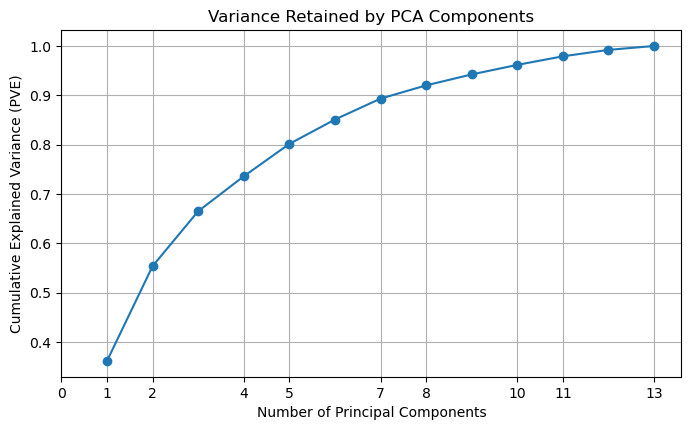

In [83]:
pve_list = np.cumsum(pca.explained_variance_ratio_)
fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
x_vals = np.arange(1, len(pve_list) + 1)
ax.plot(x_vals, pve_list, marker='o')
ax.set_xticks(np.linspace(0, len(pve_list), 10, dtype=int))
ax.set_title('Variance Retained by PCA Components')
ax.set_xlabel('Number of Principal Components');ax.set_ylabel('Cumulative Explained Variance (PVE)')
ax.grid(True)
plt.show()

In [84]:
def min_var(v, exp_var):
    acc = 0
    i = 0
    while acc < v:
        acc += exp_var[i]
        i += 1
    return i

min_var(0.70,pca.explained_variance_ratio_)

4

In [87]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_stand)

In [86]:
components = pca.components_.T 
explained = pca.explained_variance_ratio_

In [97]:
columns = X.iloc[:, :-1].columns
X_origin = np.zeros(len(columns))
Y_origin = np.zeros(len(columns))
U = components[:, 0] * 3 
V = components[:, 1] * 3
colors = plt.cm.viridis(np.linspace(0, 1, len(components)))

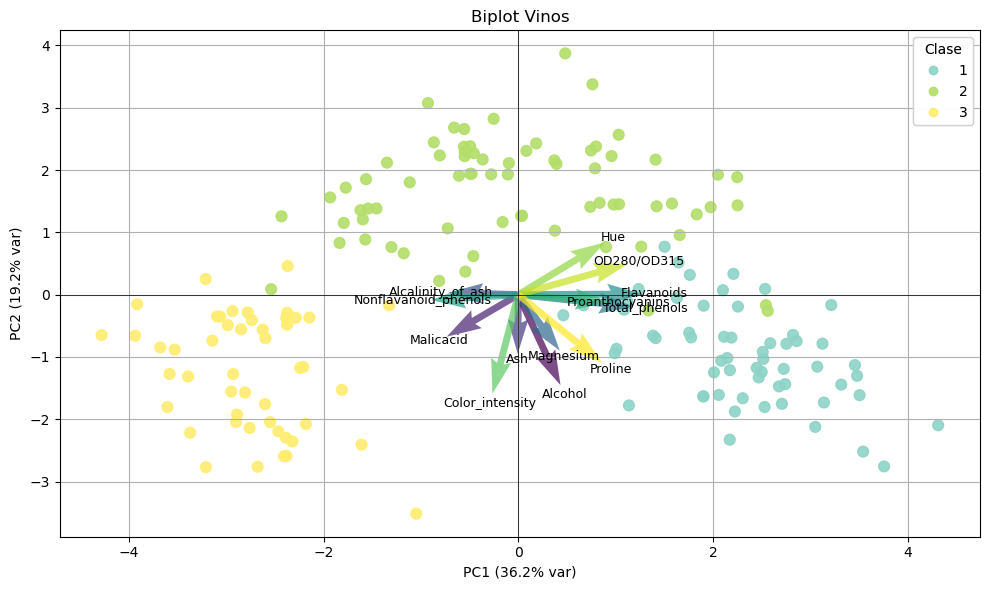

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y.to_numpy(), cmap='Set3', alpha=0.9, s=60)
legend = ax.legend(*scatter.legend_elements(), title='Clase')
ax.add_artist(legend)

ax.quiver(X_origin, Y_origin, U, V, angles='xy', scale_units='xy', scale=1, color=colors, alpha=0.7)

for i, col in enumerate(columns):
    ax.text(U[i]*1.1, V[i]*1.1, col, fontsize=9, ha='center', va='center')

ax.set_title('Biplot Vinos')
ax.set_xlabel(f'PC1 ({explained[0]*100:.1f}% var)');ax.set_ylabel(f'PC2 ({explained[1]*100:.1f}% var)')
ax.axhline(0, color='black', lw=0.5)
ax.axvline(0, color='black', lw=0.5)
ax.grid(True)

plt.tight_layout()
plt.show()


- **PC1 (36.2%)** separa principalmente por el contenido de **Flavanoids**, **Proline** y **Total_phenols**, que están alineados en su dirección, indicando que estas variables están fuertemente correlacionadas y definen la **clase 1**.

- **PC2 (19.2%)** está más influenciado por **Hue**, **OD280/OD315** y **Malicacid**, lo que sugiere que estas variables ayudan a distinguir vinos en el eje vertical, especialmente entre las **clases 2 y 3**.

- Variables como **Alcohol** y **Color_intensity** están opuestas a otras como **Malicacid**, mostrando que tienden a estar **inversamente relacionadas** en esta representación reducida.

## 3. Modelos de regresión para Proline (2.5 pts)

In [117]:
X_ = X.drop(columns=['Proline', 'class'])

Y = X['Proline']

In [118]:
X_train, X_test, Y_train, Y_test = train_test_split(X_,Y, stratify=y, test_size=0.2, random_state=707)

In [119]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=77)
rss_list = [];r2_list = []
y_val_list = []; y_pred_list = []
fold_id = []

In [125]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, X['class'].iloc[X_train.index])):
    X_tr = X_train.iloc[train_idx].to_numpy()
    X_val = X_train.iloc[val_idx].to_numpy()
    Y_tr = Y_train.iloc[train_idx].to_numpy()
    Y_val = Y_train.iloc[val_idx].to_numpy()

    betas, _ = ols(X_tr, Y_tr)

    if not np.all(X_val[:, 0] == 1):
        X_val = np.column_stack((np.ones(X_val.shape[0]), X_val))
    
    Y_val_pred = X_val @ betas
    

    rss_fold = rss(Y_val, Y_val_pred)
    r2_fold = r_squared(Y_val, Y_val_pred)

    rss_list.append(rss_fold)
    r2_list.append(r2_fold)
    y_val_list.extend(Y_val)
    y_pred_list.extend(Y_val_pred)
    fold_id.extend([fold]*len(Y_val))
    

In [126]:
y_val_list = np.array(y_val_list)
y_pred_list = np.array(y_pred_list)
fold_id = np.array(fold_id)
y_pred_list.shape

(142,)

In [127]:
resultados = {
        'RSS_mean': round(np.mean(rss_list),1),
        'RSS_std': round(np.std(rss_list),1),
        'R2_mean': round(np.mean(r2_list),1),
        'R2_std': round(np.std(r2_list),2),
    }

In [128]:
df_res = pd.DataFrame([resultados])

In [129]:
df_res

,RSS_mean,RSS_std,R2_mean,R2_std
0,987240.9,220550.4,0.6,0.14


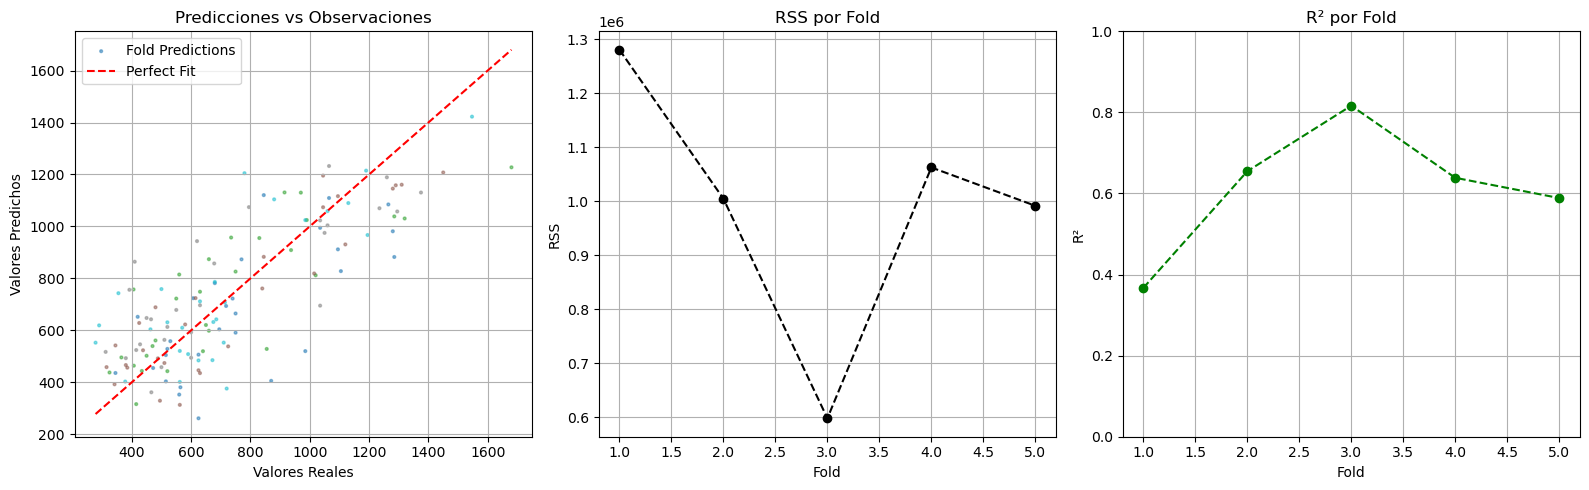

In [131]:
fig,ax = plt.subplots(1,3,figsize=(16,5))

ax[0].scatter(y_val_list, y_pred_list,c=fold_id, cmap='tab10',alpha=0.5, label='Fold Predictions',s = 4)
ax[0].plot([y_val_list.min(), y_val_list.max()],[y_val_list.min(), y_val_list.max()],'r--', label='Perfect Fit')
ax[0].set_xlabel('Valores Reales')
ax[0].set_ylabel('Valores Predichos')
ax[0].set_title('Predicciones vs Observaciones')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(range(1, len(rss_list) + 1), rss_list, marker='o', linestyle='--', color='black')
ax[1].set_xlabel('Fold')
ax[1].set_ylabel('RSS')
ax[1].set_title('RSS por Fold')
ax[1].grid(True)

ax[2].plot(range(1, len(r2_list) + 1), r2_list, marker='o', linestyle='--', color='green')
ax[2].set_xlabel('Fold')
ax[2].set_ylabel('R²')
ax[2].set_ylim(0, 1) 
ax[2].set_title('R² por Fold')
ax[2].grid(True)

plt.tight_layout()
plt.show()

In [132]:
lambdas = np.linspace(0.1, 50, 100)

In [141]:
mse_list = []
r2_list = []

In [142]:
for lm in lambdas:
    model = make_pipeline(
        StandardScaler(),
        ElasticNet(alpha=lm, l1_ratio=0.0, max_iter=10000)
    )

    model.fit(X_train, Y_train)            
    y_pred = model.predict(X_test)

    mse = rss(Y_test, y_pred) / len(Y_test)
    r2 = r_squared(Y_test, y_pred)

    mse_list.append(mse)
    r2_list.append(r2)

c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.221e+06, tolerance: 1.360e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.069e+06, tolerance: 1.360e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

In [143]:
mse_list = np.array(mse_list)
r2_list = np.array(r2_list)
min_idx = np.argmin(mse_list)

In [150]:
min_idx = np.argmin(mse_list)
print(f"Mejor MSE: {mse_list[min_idx]:.2f} con lambda = {lambdas[min_idx]}")

Mejor MSE: 60873.84 con lambda = 0.604040404040404


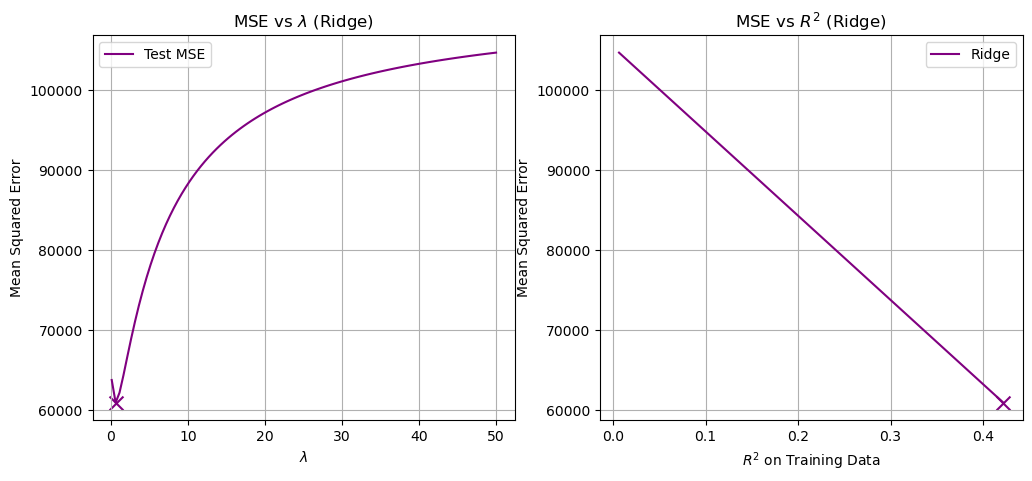

In [144]:
fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(lambdas, mse_list, color='purple', label='Test MSE')
ax[0].scatter(lambdas[min_idx], mse_list[min_idx], color='purple', marker='x', s=100)
ax[0].set_title('MSE vs $\lambda$ (Ridge)')
ax[0].set_xlabel(r'$\lambda$');ax[0].set_ylabel('Mean Squared Error')  
ax[0].grid(True)
ax[0].legend()

sorted_idx = np.argsort(r2_list)
ax[1].plot(r2_list[sorted_idx], mse_list[sorted_idx], color='purple', label='Ridge')
ax[1].scatter(r2_list[min_idx], mse_list[min_idx], color='purple', marker='x', s=100)
ax[1].set_title('MSE vs $R^2$ (Ridge)')
ax[1].set_xlabel(r'$R^2$ on Training Data');ax[1].set_ylabel('Mean Squared Error')
ax[1].grid(True)
ax[1].legend()

In [147]:
model = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=lambdas, store_cv_values=True) 
)

In [149]:
model.fit(X_train, Y_train)
ridge_cv = model.named_steps['ridgecv']
y_pred = model.predict(X_test)
print(f"Lambda óptimo (alpha): {ridge_cv.alpha_}")

Lambda óptimo (alpha): 21.773737373737376


In [151]:
mse_list = []
r2_list = []

In [152]:
for lm in lambdas:
    model = make_pipeline(
        StandardScaler(),
        ElasticNet(alpha=lm, l1_ratio=1.0, max_iter=10000) 
    )

    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)

    mse = rss(Y_test, y_pred) / len(Y_test)
    r2 = r_squared(Y_test, y_pred)

    mse_list.append(mse)
    r2_list.append(r2)

In [154]:
mse_array = np.array(mse_list)
r2_array = np.array(r2_list)
min_idx = np.argmin(mse_array)

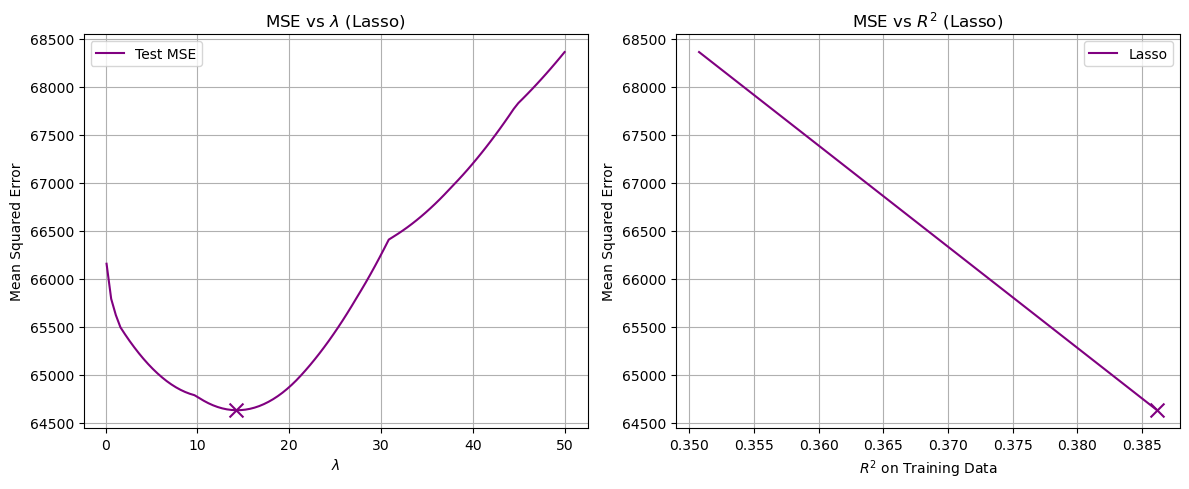

In [155]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(lambdas, mse_array, color='purple', label='Test MSE')
ax[0].scatter(lambdas[min_idx], mse_array[min_idx], color='purple', marker='x', s=100)
ax[0].set_title('MSE vs $\lambda$ (Lasso)')
ax[0].set_xlabel(r'$\lambda$');ax[0].set_ylabel('Mean Squared Error')
ax[0].grid(True)
ax[0].legend()

sorted_idx = np.argsort(r2_array)
ax[1].plot(r2_array[sorted_idx], mse_array[sorted_idx], color='purple', label='Lasso')
ax[1].scatter(r2_array[min_idx], mse_array[min_idx], color='purple', marker='x', s=100)
ax[1].set_title('MSE vs $R^2$ (Lasso)')
ax[1].set_xlabel(r'$R^2$ on Training Data');ax[1].set_ylabel('Mean Squared Error')
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()

In [156]:
model = make_pipeline(
    StandardScaler(),
    LassoCV(alphas=lambdas, cv=5, max_iter=10000)
)

In [158]:
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
lasso_cv = model.named_steps['lassocv']

In [159]:
print(f"Lambda óptimo (alpha): {lasso_cv.alpha_:.4f}")

Lambda óptimo (alpha): 8.6687


In [160]:
coef = lasso_cv.coef_ 

In [162]:
for name, value in zip(X_.columns, coef):
    if abs(value) == 0:
        print(f"{name} eliminado")

Total_phenols eliminado
Nonflavanoid_phenols eliminado


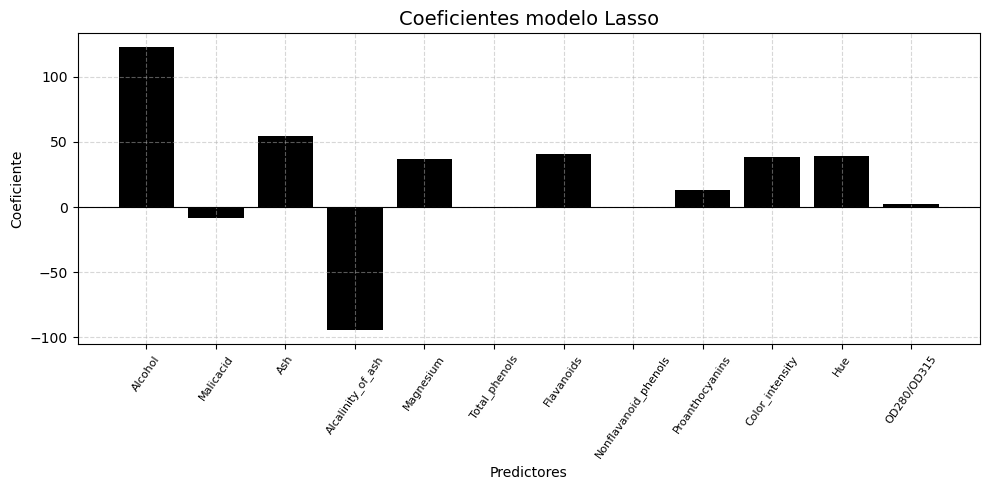

In [164]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(X_.columns, coef,color = 'black')
ax.set_title('Coeficientes modelo Lasso', fontsize=14)
ax.set_ylabel('Coeficiente');ax.set_xlabel('Predictores')
ax.tick_params(axis='x', labelrotation=55, labelsize=8)
ax.axhline(0, color='black', linewidth=0.8)  
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Los coeficientes mas importantes son el **Alcohol** el cual se relaciona positivamente con Proline, **Alcalinity_of_ash** tambien de forma negativa y despues podriamos mencionar a las variables **Ash** y **Flavanoids** que aportan de forma positiva.